In [8]:
import os
cwd = os.getcwd()
print(cwd)

/content


In [11]:
import pandas as pd

# Load the uploaded file
file_path = '/content/sample_data/compiled_risk_data.xlsx - Data Analytics.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head()

,project_name,Smart contract address,Blog post link,Audit website,Chain,Is_closed_source,hidden_owner,anti_whale_modifiable,Is_anti_whale,Is_honeypot,...,centralized_risk_high,centralized_risk_low,event_setter,external_dependencies,immutable_states,reentrancy_without_eth_transfer,incorrect_inheritance_order,shadowing_local,events_maths,Summary/rationale of risk tags marked true
0,Data Analytics,384571416209d08623c6ace9422613fc8970475d,https://chainsecurity.com/security-audit/circl...,https://chainsecurity.com,Ethereum,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,Bad Contract: Assigned for flaws that indicate...
1,Data Analytics,0xAb5801a7D398351b8bE11C439e05C5B3259ae9B,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,False,False,True,True,False,...,False,True,False,True,False,False,True,False,True,Summary/rationale of risk tags marked true: Th...
2,Data Analytics,0x4B20993Bc481177ec7E8f571ceCaE8A9e22C02db,https://stackoverflow.com/questions/71115106/s...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,False,True,False,...,False,True,False,True,False,False,False,True,True,NaN
3,Data Analytics,0x78731D3Ca6b7E34aC0F824c42a7cC18A495cabaB,https://stackoverflow.com/questions/75030483/w...,https://studygroup.moralis.io/t/compilation-er...,Ethereum,True,False,False,False,True,...,False,True,False,False,True,True,False,False,True,NaN
4,Data Analytics,0x617F2E2fD72FD9D5503197092aC168c91465E7f2,https://stackoverflow.com/questions/69466137/h...,https://ethereum.stackexchange.com/questions/1...,Ethereum,True,False,True,False,True,...,False,False,True,True,False,True,False,False,True,The smart contract is marked with risks such a...


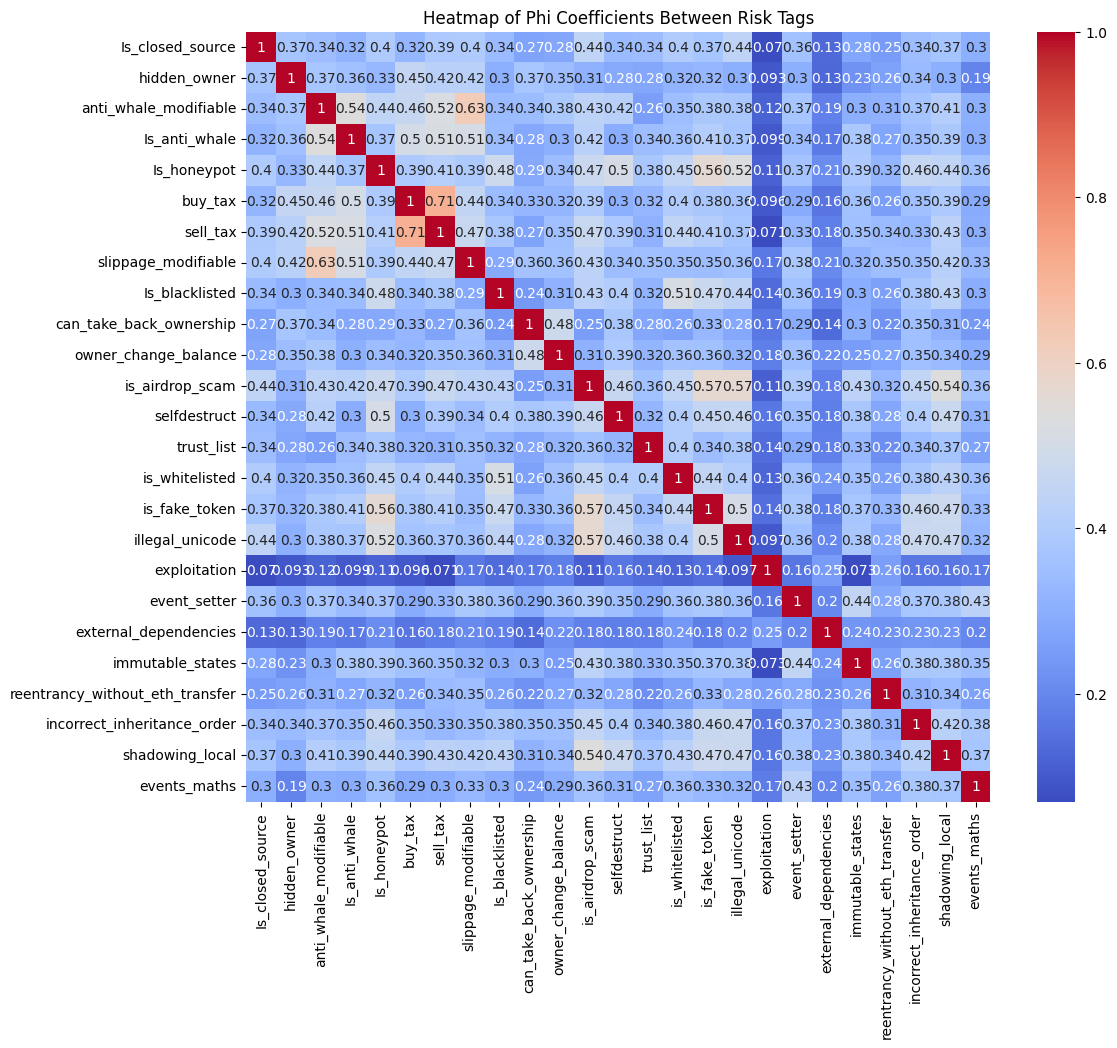

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extract binary risk tag columns (boolean columns)
binary_columns = data.select_dtypes(include=[bool])

# Function to calculate phi coefficient for two binary variables
def phi_coefficient(x, y):
    cm = confusion_matrix(x, y)
    if cm.shape == (2, 2):
        n = np.sum(cm)
        phi = (cm[0, 0] * cm[1, 1] - cm[0, 1] * cm[1, 0]) / np.sqrt(
            (cm[0, 0] + cm[0, 1]) * (cm[0, 0] + cm[1, 0]) * (cm[1, 1] + cm[0, 1]) * (cm[1, 1] + cm[1, 0])
        )
        return phi
    else:
        return np.nan

# Calculate the phi coefficient matrix
phi_matrix = np.zeros((binary_columns.shape[1], binary_columns.shape[1]))

for i in range(binary_columns.shape[1]):
    for j in range(binary_columns.shape[1]):
        phi_matrix[i, j] = phi_coefficient(binary_columns.iloc[:, i], binary_columns.iloc[:, j])

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, annot=True, cmap='coolwarm', xticklabels=binary_columns.columns, yticklabels=binary_columns.columns)
plt.title('Heatmap of Phi Coefficients Between Risk Tags')
plt.show()

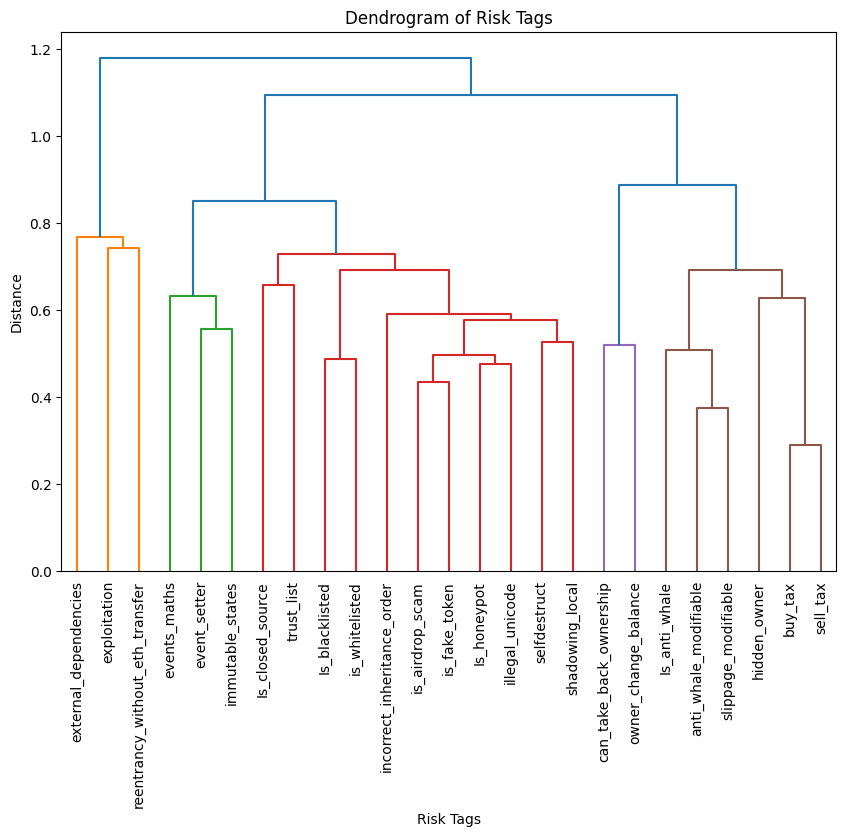

                           Risk Tag  Cluster
0                  Is_closed_source        1
22      incorrect_inheritance_order        1
21  reentrancy_without_eth_transfer        1
20                 immutable_states        1
19            external_dependencies        1
18                     event_setter        1
17                     exploitation        1
16                  illegal_unicode        1
15                    is_fake_token        1
14                   is_whitelisted        1
13                       trust_list        1
23                  shadowing_local        1
12                     selfdestruct        1
10             owner_change_balance        1
9           can_take_back_ownership        1
8                    Is_blacklisted        1
7               slippage_modifiable        1
6                          sell_tax        1
5                           buy_tax        1
4                       Is_honeypot        1
3                     Is_anti_whale        1
2         

<ipython-input-13-fbf6c1cfde8d>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=clustered_data, palette='Set2')


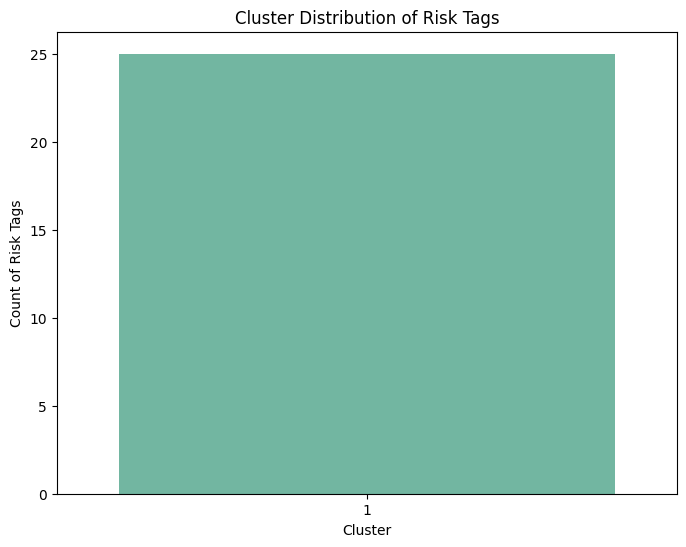

In [13]:
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform

# Convert phi coefficients to distances (1 - phi to get a dissimilarity measure)
phi_distances = 1 - phi_matrix

# Create a condensed distance matrix, required for hierarchical clustering
condensed_dist_matrix = squareform(phi_distances)

# Generate the dendrogram using the linkage matrix
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(condensed_dist_matrix, method='ward'), labels=binary_columns.columns, leaf_rotation=90)
plt.title('Dendrogram of Risk Tags')
plt.xlabel('Risk Tags')
plt.ylabel('Distance')
plt.show()

# For cluster distribution, we can cut the dendrogram at an optimal point and display clusters
from scipy.cluster.hierarchy import fcluster

# Set a threshold to form flat clusters (this can be adjusted based on the dendrogram)
max_distance = 1.5  # Adjust this value based on visual inspection of the dendrogram
clusters = fcluster(sch.linkage(condensed_dist_matrix, method='ward'), max_distance, criterion='distance')

# Display the clusters
clustered_data = pd.DataFrame({'Risk Tag': binary_columns.columns, 'Cluster': clusters})
print(clustered_data.sort_values(by='Cluster'))

plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=clustered_data, palette='Set2')
plt.title('Cluster Distribution of Risk Tags')
plt.xlabel('Cluster')
plt.ylabel('Count of Risk Tags')
plt.show()

<ipython-input-14-bdcdeb424178>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_counts.index, y=true_counts.values, palette="viridis")


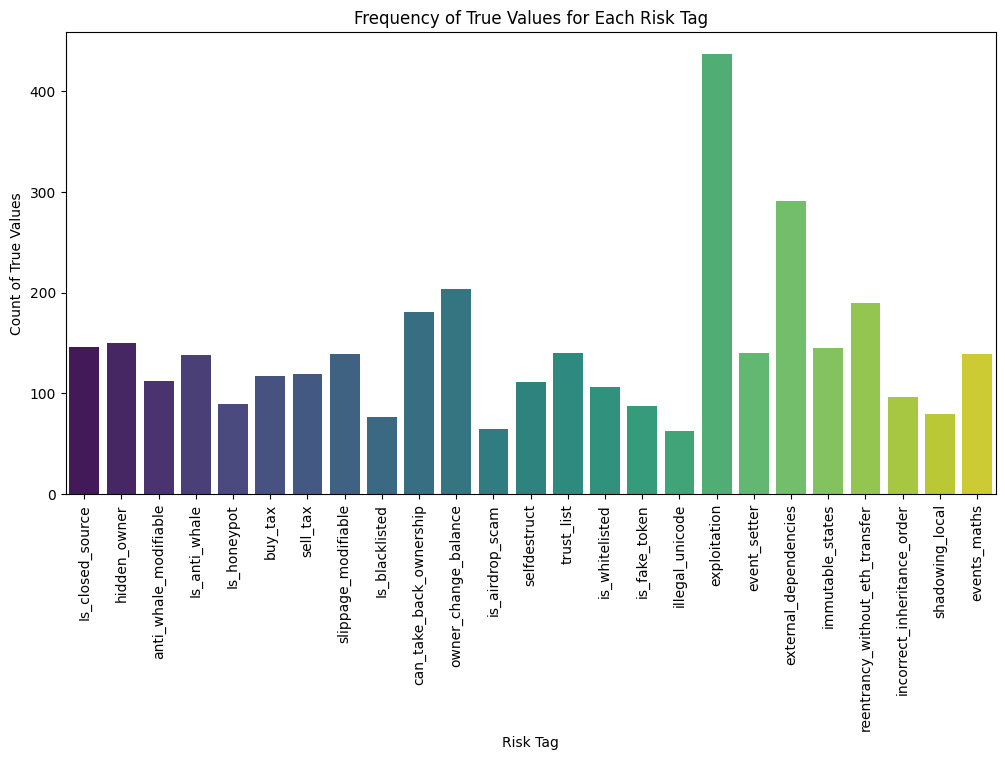

In [14]:
# Let's create a bar plot showing the frequency of 'True' values for each binary risk tag column.

# Count the frequency of True values for each risk tag
true_counts = binary_columns.sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=true_counts.index, y=true_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('Frequency of True Values for Each Risk Tag')
plt.xlabel('Risk Tag')
plt.ylabel('Count of True Values')
plt.show()